In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get the dataset

In [3]:
import urllib.request
from zipfile import ZipFile

dataDir = 'dataset'

datasetUrl = 'https://archive.ics.uci.edu/static/public/45/heart+disease.zip'
datasetZipFile = os.path.join(dataDir, 'heart-disease.zip')
if not os.path.isdir(dataDir):
    os.makedirs(dataDir)
urllib.request.urlretrieve(datasetUrl, datasetZipFile)

with ZipFile(datasetZipFile, 'r') as f:
    f.extractall(dataDir)

### Notes
Need to determine whether it makes sense for columns with discrete values to be represented using ordinal encoding or one-hot encoding.
If the values are based on binning a continuous variable, then the values are ordered as they should be.
If the values are arbitrarily assigned based on category, then they should be transformed using something like one-hot encoding.

Column descriptions taken from https://archive.ics.uci.edu/dataset/45/heart+disease:

age: age in years

sex: sex

  - Value 0: female
  
  - Value 1: male

cp: chest pain type

  - Value 1: typical angina

  - Value 2: atypical angina

  - Value 3: non-anginal pain

  - Value 4: asymptomatic

trestbps: resting blood pressure (in mm Hg on admission to the hospital)

chol: serum cholestoral in mg/dl

fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

restecg: resting electrocardiographic results

  - Value 0: normal

  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

thalach: maximum heart rate achieved

exang: exercise induced angina (1 = yes; 0 = no)

oldpeak = ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

  - Value 1: upsloping

  - Value 2: flat

  - Value 3: downsloping

ca: number of major vessels (0-3) colored by flourosopy

thal:

  - Value 3: normal
  
  - Value 6: fixed defect

  - Value 7: reversible defect

num: diagnosis of heart disease (target)

## Load the dataset and explore

In [4]:
clevelandDataFile = os.path.join(dataDir, 'processed.cleveland.data')

In [5]:
columnNames = [  # obtained from https://archive.ics.uci.edu/dataset/45/heart+disease
    'age',
    'sex',
    'cp',
    'trestbps',
    'chol',
    'fbs',
    'restecg',
    'thalach',
    'exang',
    'oldpeak',
    'slope',
    'ca',
    'thal',
    'num'
]
clevelandData = pd.read_csv(
    clevelandDataFile,
    header=None,
    names=columnNames
)

In [6]:
clevelandData.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Columns 11 and 12 (`ca` and `thal`) are of Dtype `object`, which probably means that they have missing values.

In [7]:
clevelandData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


Looking at histograms of the column values, one can make the following observations:
- `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, and `num` are discrete variables (as expected based on column descriptions)
- `trestbps`, `chol`, and `oldpeak` might have outliers
- `trestbps` appears to have much larger counts for a small set of discrete values, possibly indicating binning for some subset of the data
- `age` could be multi-modal
- `oldpeak` has a much larger number of 0 values compared to the others
- `restecg` has a very small number of entries with value 1 compared to 0 and 2
- `ca` and `thal` don't show up because they are of type `object` at this point

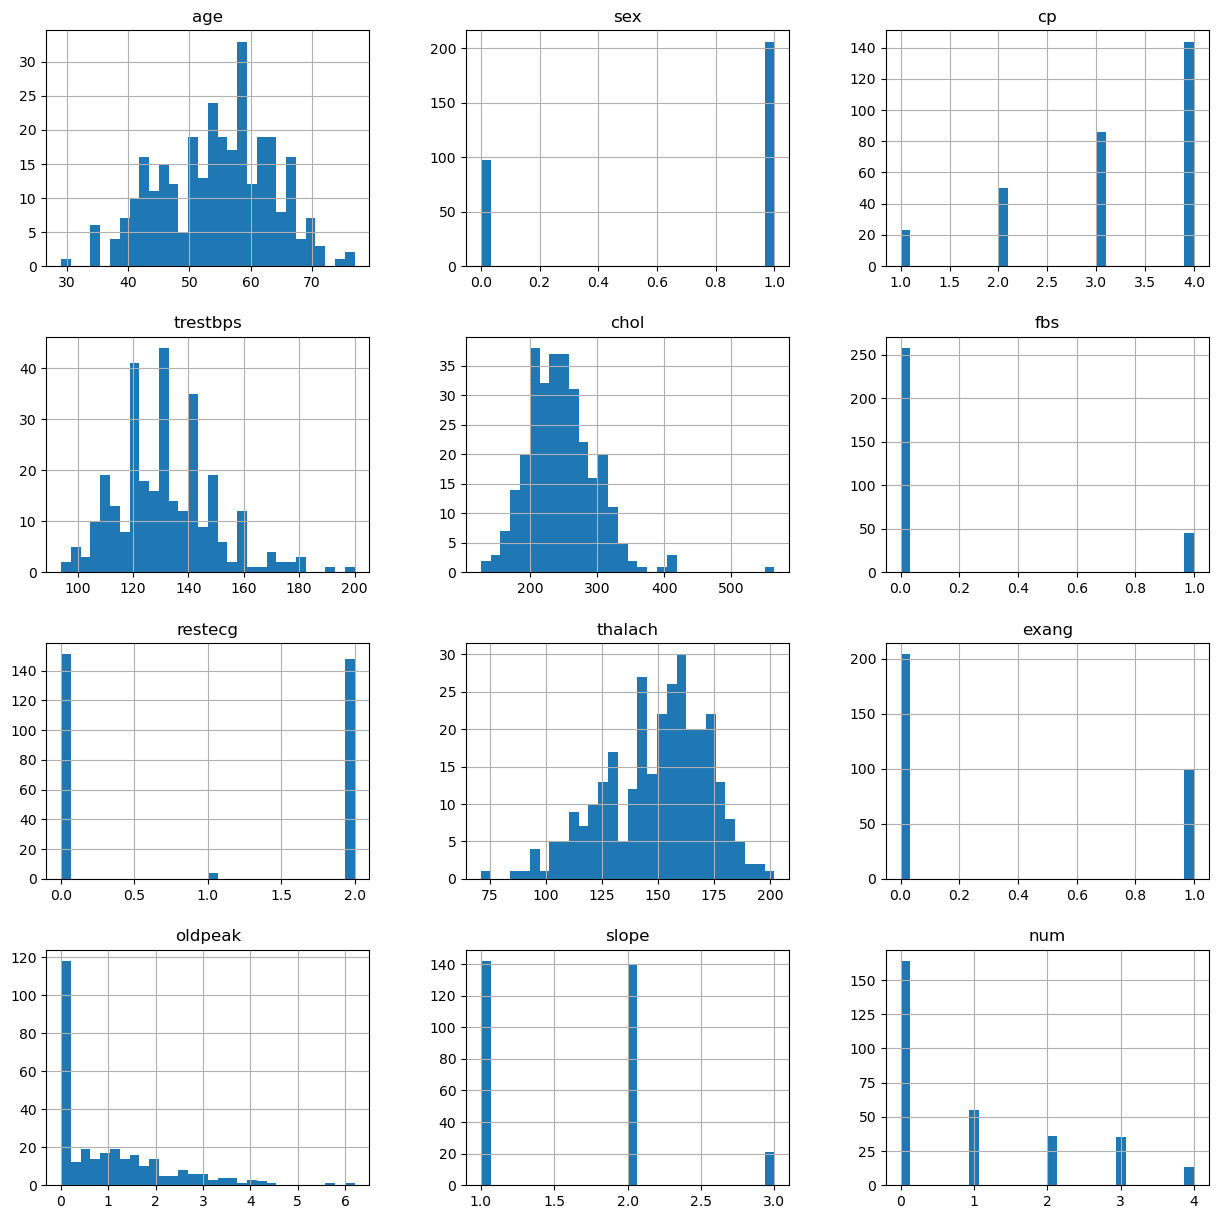

In [8]:
clevelandData.hist(bins=30, figsize=(15,15))
plt.show()

Looking at the counts for the unique values in columns `ca` and `thal`, we confirm that these columns appear to have missing values indicated by `'?'`.

In [9]:
clevelandData['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

In [10]:
clevelandData['thal'].value_counts()

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64

## Data cleaning

#### Replace `'?'` (missing values) with NaNs

In [11]:
clevelandData['ca'] = clevelandData['ca'].apply(lambda x: np.nan if x=='?' else np.float64(x))
clevelandData['thal'] = clevelandData['thal'].apply(lambda x: np.nan if x=='?' else np.float64(x))

#### Impute NaNs with the median
Another option would be to drop the rows with NaNs since there are a small number of them).
Question: does using the median make sense here? Would using the mode also make sense?

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(clevelandData)

SimpleImputer(strategy='median')

## Transform columns from ordinal to one-hot encoding

A few of the possible candidates for transform:

sex

cp: chest pain type

  - Value 1: typical angina

  - Value 2: atypical angina

  - Value 3: non-anginal pain

  - Value 4: asymptomatic

restecg: resting electrocardiographic results

  - Value 0: normal

  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

slope: the slope of the peak exercise ST segment

  - Value 1: upsloping

  - Value 2: flat

  - Value 3: downsloping

In [13]:
numerical_cols = [
    'age',
    'trestbps',
    'chol',
    'fbs',
    'thalach',
    'exang',
    'oldpeak',
    'ca',
    'thal'
]
categorical_cols = ['sex', 'cp', 'restecg', 'slope']

## Make target variable binary

Based on the dataset description, any entries with values of the `num` column that are greater than zero should be considered as having heart disease, and entries with values of zero should be considered as not having heart disease.

In [14]:
clevelandData['target'] = clevelandData['num'].apply(lambda x: 1 if x > 0 else 0)
clevelandData.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


## Create a test set

Create train and test datasets by stratifying based on the `num` categorical value (target variable). This ensures that both datasets will have similar distributions of the target variable.

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for idx_train, idx_test in splitter.split(clevelandData, clevelandData['num']):
    clevelandData_train = clevelandData.loc[idx_train]
    clevelandData_test = clevelandData.loc[idx_test]

We confirm that the stratification strategy worked by comparing histograms of the `num` column.

In [16]:
clevelandData_train['num'].value_counts() / clevelandData_train.shape[0]

0    0.541322
1    0.181818
2    0.119835
3    0.115702
4    0.041322
Name: num, dtype: float64

In [17]:
clevelandData_test['num'].value_counts() / clevelandData_test.shape[0]

0    0.540984
1    0.180328
3    0.114754
2    0.114754
4    0.049180
Name: num, dtype: float64

In [18]:
clevelandData['num'].value_counts() / clevelandData.shape[0]

0    0.541254
1    0.181518
2    0.118812
3    0.115512
4    0.042904
Name: num, dtype: float64

In [19]:
for set_ in (clevelandData_train, clevelandData_test):
    set_.drop("num", axis=1, inplace=True)

## Look for correlations between columns

Interestingly, the target variable has very low correlation with respect to cholesterol level! However, there is probably more to this story that is worth investigating.

In [20]:
corr_matrix = clevelandData_train.corr()
corr_matrix['target'].sort_values(ascending=False)

target      1.000000
thal        0.517511
exang       0.461128
ca          0.444122
oldpeak     0.429481
cp          0.406746
slope       0.333476
age         0.247669
sex         0.207485
trestbps    0.180018
restecg     0.153355
chol        0.051334
fbs         0.034667
thalach    -0.444231
Name: target, dtype: float64

It's hard to make sense of a lot of these scatter plots given that we have discrete variables.

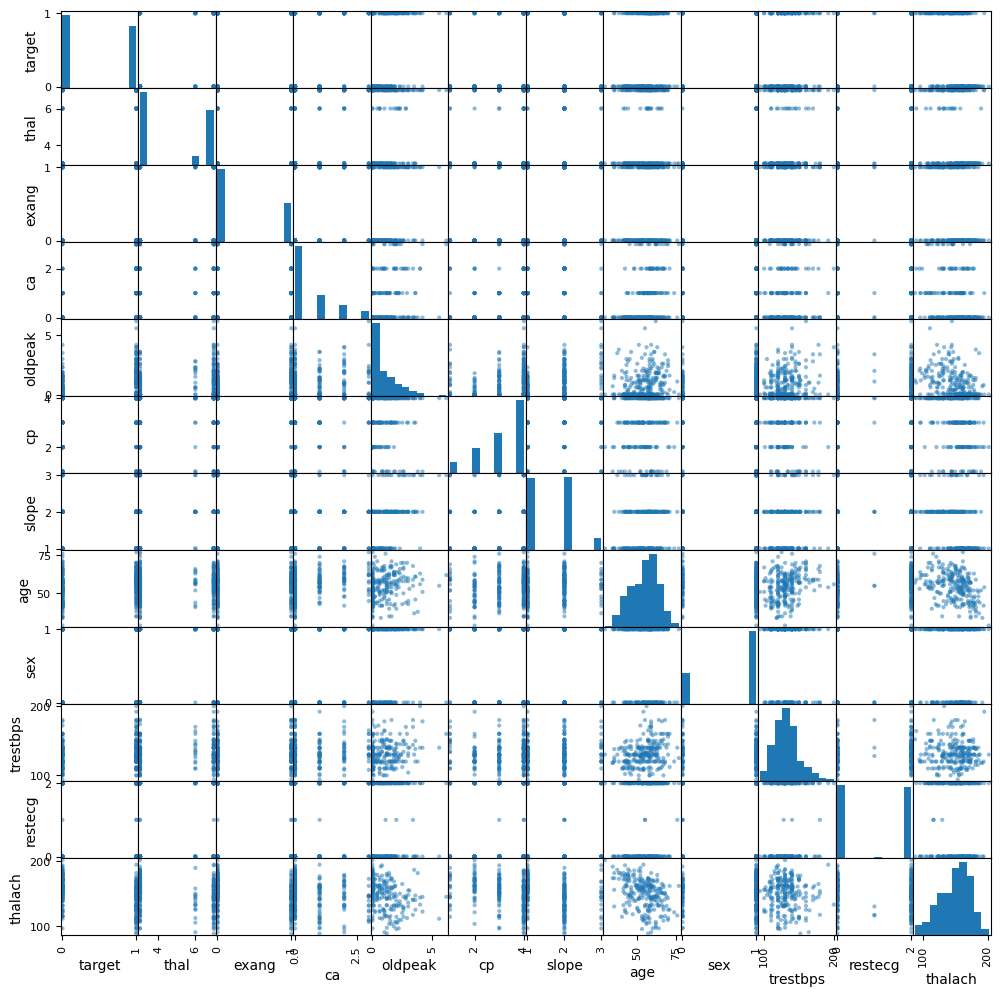

In [21]:
from pandas.plotting import scatter_matrix

attributes = [
    'target', 'thal', 'exang', 'ca', 'oldpeak', 'cp', 'slope', 'age', 'sex',
    'trestbps', 'restecg', 'thalach'
]
scatter_matrix(
    clevelandData_train[attributes],
    figsize=(12,12)
)
plt.show()

## Build pipelines

Now we put together our data transformations into a "pipeline" for ease of use.

In [22]:
train_y = clevelandData_train['target'].copy().to_numpy()
clevelandData_train_X = clevelandData_train.drop('target', axis=1)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols)
])

train_X = full_pipeline.fit_transform(clevelandData_train_X)

In [24]:
train_X.shape

(242, 21)

In [25]:
train_y.shape

(242,)

## Train and evaluate models

The random forest, SVM, and logistic regression classifiers trained here perform competitively with each other, whereas the tree classifier performs worse. However, mostly default hyperparameter values were used here, and model performance can strongly depend on hyperparameter values, as will soon be seen. 

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [31]:
tree_clf = DecisionTreeClassifier(random_state=1234)
scores = cross_val_score(tree_clf, train_X, train_y,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [0.57142857 0.51507875 0.61237244 0.54006172 0.5204165 ]
Mean: 0.5518715970991867
Standard deviation: 0.036125991390803885


In [32]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=1234)
forest_scores = cross_val_score(forest_clf, train_X, train_y,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.37796447 0.40406102 0.45643546 0.38188131 0.40824829]
Mean: 0.40571811075891995
Standard deviation: 0.027999483295193445


In [33]:
svm_clf = SVC(kernel='linear', random_state=1234)
svm_scores = cross_val_score(svm_clf, train_X, train_y,
                                scoring="neg_mean_squared_error", cv=5)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [0.34992711 0.40406102 0.4330127  0.40824829 0.40824829]
Mean: 0.40069948135054245
Standard deviation: 0.02737607449818351


In [34]:
log_reg = LogisticRegression(penalty='l2', random_state=1234)  # L2 regularization is used by default
log_reg_scores = cross_val_score(log_reg, train_X, train_y,
                                scoring="neg_mean_squared_error", cv=5)
log_reg_rmse_scores = np.sqrt(-log_reg_scores)
display_scores(log_reg_rmse_scores)

Scores: [0.37796447 0.40406102 0.4330127  0.40824829 0.40824829]
Mean: 0.40630695473001144
Standard deviation: 0.01748756702945038


## Grid search hyperparameters

We perform hyperparameter tuning on the best-performing model types using grid searches. We get some performance improvement for all three model types. However, the best-performing random forest classifiers show signs of overfitting.

In [36]:
from sklearn.model_selection import GridSearchCV

### Logistic regression

In [38]:
param_grid = [
    # try 7 combinations of hyperparameters
    {'C': [1/10, 1/4, 1/2, 1, 2, 4, 10],
     'penalty': ['l2', 'l1']},
  ]

log_reg = LogisticRegression(solver='liblinear', random_state=1234)
grid_search = GridSearchCV(log_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_X, train_y)

print(grid_search.best_params_)
cvres = grid_search.cv_results_
idx = np.argsort(cvres['mean_test_score'])[::-1]
for k in idx:
    print(
        'Test score = %.3f+\-%.3f' % (np.sqrt(-cvres['mean_test_score'][k]), np.sqrt(cvres['std_test_score'][k])),
        'Train score = %.3f+\-%.3f' % (np.sqrt(-cvres['mean_train_score'][k]), np.sqrt(cvres['std_train_score'][k])),
        cvres['params'][k]
    )

{'C': 0.1, 'penalty': 'l2'}
Test score = 0.391+\-0.199 Train score = 0.365+\-0.103 {'C': 0.1, 'penalty': 'l2'}
Test score = 0.397+\-0.170 Train score = 0.364+\-0.102 {'C': 1, 'penalty': 'l1'}
Test score = 0.397+\-0.150 Train score = 0.361+\-0.104 {'C': 0.5, 'penalty': 'l2'}
Test score = 0.402+\-0.127 Train score = 0.362+\-0.118 {'C': 10, 'penalty': 'l1'}
Test score = 0.402+\-0.127 Train score = 0.365+\-0.106 {'C': 4, 'penalty': 'l1'}
Test score = 0.402+\-0.127 Train score = 0.364+\-0.109 {'C': 4, 'penalty': 'l2'}
Test score = 0.402+\-0.127 Train score = 0.366+\-0.108 {'C': 2, 'penalty': 'l2'}
Test score = 0.402+\-0.176 Train score = 0.362+\-0.093 {'C': 0.5, 'penalty': 'l1'}
Test score = 0.402+\-0.183 Train score = 0.362+\-0.104 {'C': 0.25, 'penalty': 'l1'}
Test score = 0.402+\-0.185 Train score = 0.361+\-0.091 {'C': 0.25, 'penalty': 'l2'}
Test score = 0.407+\-0.119 Train score = 0.361+\-0.114 {'C': 10, 'penalty': 'l2'}
Test score = 0.407+\-0.119 Train score = 0.362+\-0.105 {'C': 2, 'pe

### SVM

In [39]:
param_grid = [
    {'C': [1/10, 1/4, 1/2, 1, 2, 4, 10],
     'kernel': ['linear', 'rbf']},
  ]

svm_clf = SVC(random_state=1234)
grid_search = GridSearchCV(svm_clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_X, train_y)

print(grid_search.best_params_)
cvres = grid_search.cv_results_
idx = np.argsort(cvres['mean_test_score'])[::-1]
for k in idx:
    print(
        'Test score = %.3f+\-%.3f' % (np.sqrt(-cvres['mean_test_score'][k]), np.sqrt(cvres['std_test_score'][k])),
        'Train score = %.3f+\-%.3f' % (np.sqrt(-cvres['mean_train_score'][k]), np.sqrt(cvres['std_train_score'][k])),
        cvres['params'][k]
    )

{'C': 0.5, 'kernel': 'linear'}
Test score = 0.391+\-0.171 Train score = 0.356+\-0.111 {'C': 0.5, 'kernel': 'linear'}
Test score = 0.396+\-0.148 Train score = 0.358+\-0.138 {'C': 4, 'kernel': 'linear'}
Test score = 0.397+\-0.170 Train score = 0.351+\-0.112 {'C': 0.25, 'kernel': 'linear'}
Test score = 0.397+\-0.170 Train score = 0.361+\-0.078 {'C': 0.1, 'kernel': 'linear'}
Test score = 0.402+\-0.146 Train score = 0.361+\-0.129 {'C': 2, 'kernel': 'linear'}
Test score = 0.402+\-0.146 Train score = 0.359+\-0.128 {'C': 1, 'kernel': 'linear'}
Test score = 0.407+\-0.153 Train score = 0.366+\-0.081 {'C': 0.1, 'kernel': 'rbf'}
Test score = 0.407+\-0.211 Train score = 0.176+\-0.058 {'C': 4, 'kernel': 'rbf'}
Test score = 0.412+\-0.156 Train score = 0.355+\-0.133 {'C': 10, 'kernel': 'linear'}
Test score = 0.412+\-0.158 Train score = 0.265+\-0.112 {'C': 1, 'kernel': 'rbf'}
Test score = 0.422+\-0.197 Train score = 0.232+\-0.118 {'C': 2, 'kernel': 'rbf'}
Test score = 0.422+\-0.171 Train score = 0.315+

### Random forest

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 100],
     'max_features': [2, 4, 6, 8, 12, 14],
     'max_depth': [None, 2, 4, 16, 32]},
  ]

forest_clf = RandomForestClassifier(random_state=1234)
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_X, train_y)

print(grid_search.best_params_)
cvres = grid_search.cv_results_
idx = np.argsort(cvres['mean_test_score'])[::-1]
for k in idx:
    print(
        'Test score = %.3f+\-%.3f' % (np.sqrt(-cvres['mean_test_score'][k]), np.sqrt(cvres['std_test_score'][k])),
        'Train score = %.3f+\-%.3f' % (np.sqrt(-cvres['mean_train_score'][k]), np.sqrt(cvres['std_train_score'][k])),
        cvres['params'][k]
    )

{'max_depth': 4, 'max_features': 6, 'n_estimators': 30}
Test score = 0.380+\-0.188 Train score = 0.278+\-0.068 {'max_depth': 4, 'max_features': 6, 'n_estimators': 30}
Test score = 0.386+\-0.169 Train score = 0.032+\-0.045 {'max_depth': 16, 'max_features': 4, 'n_estimators': 30}
Test score = 0.386+\-0.169 Train score = 0.032+\-0.045 {'max_depth': None, 'max_features': 4, 'n_estimators': 30}
Test score = 0.386+\-0.169 Train score = 0.032+\-0.045 {'max_depth': 32, 'max_features': 4, 'n_estimators': 30}
Test score = 0.386+\-0.213 Train score = 0.267+\-0.077 {'max_depth': 4, 'max_features': 8, 'n_estimators': 30}
Test score = 0.391+\-0.170 Train score = 0.354+\-0.126 {'max_depth': 2, 'max_features': 6, 'n_estimators': 30}
Test score = 0.391+\-0.162 Train score = 0.362+\-0.102 {'max_depth': 2, 'max_features': 6, 'n_estimators': 10}
Test score = 0.391+\-0.209 Train score = 0.349+\-0.085 {'max_depth': 2, 'max_features': 8, 'n_estimators': 100}
Test score = 0.396+\-0.197 Train score = 0.255+\-0

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, clevelandData_train_X.columns), reverse=True)

## Learning curve

To further investigate the amount of overfitting in each type of model, we calculate learning curves. For the random forest classifier shown here, the hyperparameter values were chosen from the grid search results from above such that there was a more balanced tradeoff between training loss and validation loss. Based on the look of the learning curve, the tradeoff works well.

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, random_state):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for idx_train, idx_val in splitter.split(X, y):
        X_train = X[idx_train]
        X_val = X[idx_val]
        y_train = y[idx_train]
        y_val = y[idx_val]
    train_errors, val_errors = [], []
    for m in range(10, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    fig, ax = plt.subplots()
    ax.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    ax.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    ax.legend(loc="upper right", fontsize=14)
    ax.set_xlabel("Training set size", fontsize=14)
    ax.set_ylabel("RMSE", fontsize=14)
    return fig, ax

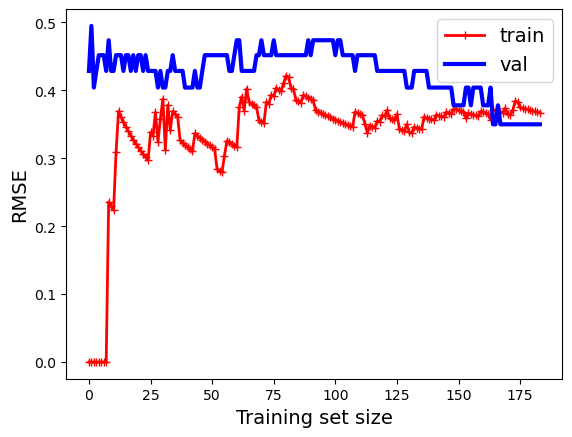

In [42]:
log_reg = LogisticRegression(penalty='l2', C=0.1, random_state=1234)  # L2 regularization is used by default
fig, ax = plot_learning_curves(log_reg, train_X, train_y, random_state=1234)
plt.show()

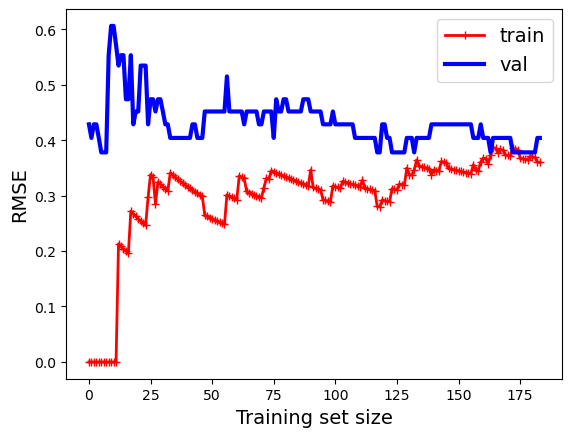

In [43]:
svm_clf = SVC(kernel='linear', C=0.5, random_state=1234)
fig, ax = plot_learning_curves(svm_clf, train_X, train_y, random_state=1234)
plt.show()

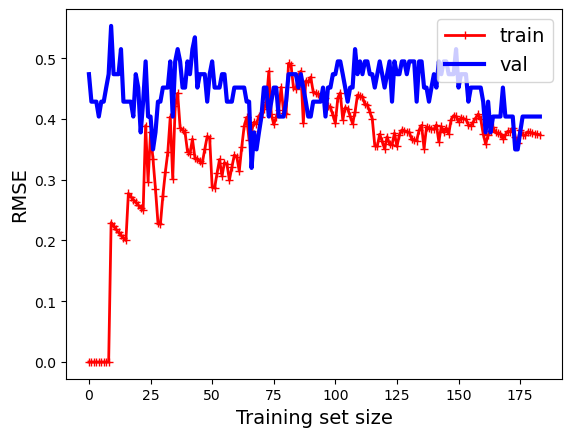

In [44]:
forest_clf = RandomForestClassifier(max_depth=2, max_features=6, n_estimators=10, random_state=1234)
fig, ax = plot_learning_curves(forest_clf, train_X, train_y, random_state=1234)
plt.show()

## Confusion matrix

In [50]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score

log_reg = LogisticRegression(penalty='l2', C=0.1, random_state=1234)
y_train_pred = cross_val_predict(log_reg, train_X, train_y, cv=5)
conf_mat = confusion_matrix(train_y, y_train_pred)
print(conf_mat)

TP, FP, FN, TN = conf_mat[0,0], conf_mat[0,1], conf_mat[1,0], conf_mat[1,1]
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
acc = (TP + TN) / (TP + TN + FP + FN)
print('acc = %.3f' % acc)
print('precision = %.3f' % precision)
print('recall = %.3f' % recall)
print('f1 = %.3f' % f1_score(train_y, y_train_pred))

[[117  14]
 [ 24  87]]
acc = 0.843
precision = 0.893
recall = 0.830
f1 = 0.821


In [49]:
svm_clf = SVC(kernel='linear', C=0.5, random_state=1234)
y_train_pred = cross_val_predict(svm_clf, train_X, train_y, cv=5)
conf_mat = confusion_matrix(train_y, y_train_pred)
print(conf_mat)

TP, FP, FN, TN = conf_mat[0,0], conf_mat[0,1], conf_mat[1,0], conf_mat[1,1]
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
acc = (TP + TN) / (TP + TN + FP + FN)
print('acc = %.3f' % acc)
print('precision = %.3f' % precision)
print('recall = %.3f' % recall)
print('f1 = %.3f' % f1_score(train_y, y_train_pred))

[[116  15]
 [ 22  89]]
acc = 0.847
precision = 0.885
recall = 0.841
f1 = 0.828


In [48]:
forest_clf = RandomForestClassifier(max_depth=2, max_features=6, n_estimators=5, random_state=1234)
y_train_pred = cross_val_predict(forest_clf, train_X, train_y, cv=10)
conf_mat = confusion_matrix(train_y, y_train_pred)
print(conf_mat)

TP, FP, FN, TN = conf_mat[0,0], conf_mat[0,1], conf_mat[1,0], conf_mat[1,1]
TP, FP, FN, TN = conf_mat[0,0], conf_mat[0,1], conf_mat[1,0], conf_mat[1,1]
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
acc = (TP + TN) / (TP + TN + FP + FN)
print('acc = %.3f' % acc)
print('precision = %.3f' % precision)
print('recall = %.3f' % recall)
print('f1 = %.3f' % f1_score(train_y, y_train_pred))

[[114  17]
 [ 27  84]]
acc = 0.818
precision = 0.870
recall = 0.809
f1 = 0.792


## Precision vs. recall

In [51]:
from sklearn.metrics import precision_recall_curve

def plot_precision_vs_recall(precisions, recalls, ax, colorAndProps):
    ax.plot(recalls, precisions, colorAndProps, linewidth=2)
    ax.set_xlabel("Recall", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True)

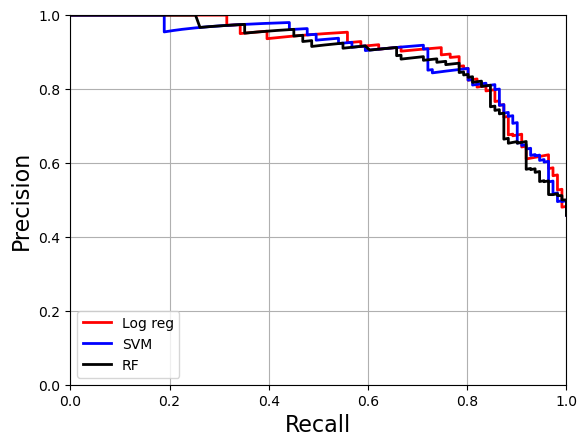

In [53]:
fig, ax = plt.subplots()

# logistic regression
log_reg = LogisticRegression(penalty='l2', C=0.1, random_state=1234)
y_train_scores = cross_val_predict(log_reg, train_X, train_y, cv=5,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(train_y, y_train_scores)
plot_precision_vs_recall(precisions, recalls, ax, 'r-')

# SVM
svm_clf = SVC(kernel='linear', C=0.5, random_state=1234)
y_train_scores = cross_val_predict(svm_clf, train_X, train_y, cv=5,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(train_y, y_train_scores)
plot_precision_vs_recall(precisions, recalls, ax, 'b-')

# random forest
forest_clf = RandomForestClassifier(max_depth=2, max_features=6, n_estimators=10, random_state=1234)
y_train_scores = cross_val_predict(forest_clf, train_X, train_y, cv=5,
                             method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(train_y, y_train_scores[:,1])
plot_precision_vs_recall(precisions, recalls, ax, 'k-')

ax.legend(['Log reg', 'SVM', 'RF'])
plt.show()

# Dimensionality reduction

In [54]:
from sklearn.decomposition import PCA

pca = PCA()
train_X_pca = pca.fit_transform(train_X)

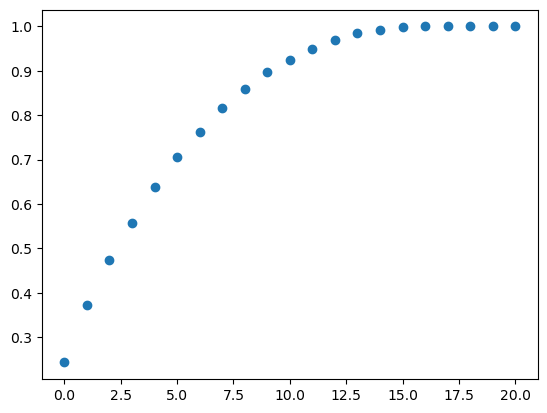

In [55]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.show()

In [56]:
log_reg = LogisticRegression(penalty='l2', C=0.1, random_state=1234)  # L2 regularization is used by default
log_reg_scores = cross_val_score(log_reg, train_X_pca[:,:10], train_y,
                                scoring="neg_mean_squared_error", cv=5)
log_reg_rmse_scores = np.sqrt(-log_reg_scores)
display_scores(log_reg_rmse_scores)

Scores: [0.37796447 0.37796447 0.40824829 0.4330127  0.40824829]
Mean: 0.4010876457676799
Standard deviation: 0.020933805723372133


In [57]:
from sklearn.manifold import TSNE
train_X_tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='pca',
    perplexity=50
).fit_transform(train_X)

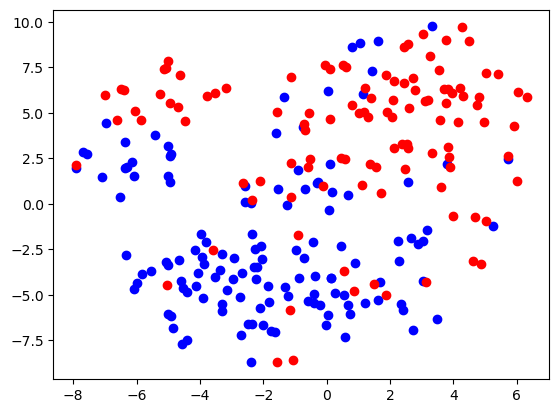

In [58]:
fig, ax = plt.subplots()
ax.plot(
    train_X_tsne[train_y==0,0],
    train_X_tsne[train_y==0,1],
    'bo'
)
ax.plot(
    train_X_tsne[train_y==1,0],
    train_X_tsne[train_y==1,1],
    'ro'
)
plt.show()

## Performance on test set

In [59]:
from sklearn.metrics import f1_score

In [60]:
test_y = clevelandData_test['target'].copy().to_numpy()
clevelandData_test_X = clevelandData_test.drop('target', axis=1)
test_X = full_pipeline.fit_transform(clevelandData_test_X)

In [61]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=1234)
forest_clf.fit(train_X, train_y)
print(f'acc = {forest_clf.score(test_X, test_y)}')
print(f'f1 = {f1_score(test_y, forest_clf.predict(test_X))}')

acc = 0.8032786885245902
f1 = 0.7692307692307692


In [62]:
log_reg = LogisticRegression(penalty='l2', C=0.1, random_state=1234)
log_reg.fit(train_X, train_y)
print(f'acc = {log_reg.score(test_X, test_y)}')
print(f'f1 = {f1_score(test_y, log_reg.predict(test_X))}')

acc = 0.8360655737704918
f1 = 0.8148148148148148


In [63]:
svm_clf = SVC(kernel='linear', C=0.5, random_state=1234)
svm_clf.fit(train_X, train_y)
print(f'acc = {svm_clf.score(test_X, test_y)}')
print(f'f1 = {f1_score(test_y, svm_clf.predict(test_X))}')

acc = 0.819672131147541
f1 = 0.7924528301886793
